# Multimodal Memotion Analysis
**Final Assignment**  
Tasks:  
A. Sentiment Classification  
B. Humor/Sarcasm/Offense Detection  
C. Motivational Classification


## Configuration & Imports
Import required libraries and set up hardware acceleration

In [37]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image, ImageFile
from transformers import DistilBertTokenizer, DistilBertModel, ViTImageProcessor, ViTModel
import torch.nn as nn
import os
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
# Enable truncated image handling
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Hardware configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True

## Data Analysis for Labels

In [38]:
labels_df = pd.read_csv('labels.csv')
print(f"Total samples: {len(labels_df)}")
print(f"Columns: {list(labels_df.columns)}")

Total samples: 6992
Columns: ['Unnamed: 0', 'image_name', 'text_ocr', 'text_corrected', 'humour', 'sarcasm', 'offensive', 'motivational', 'overall_sentiment']


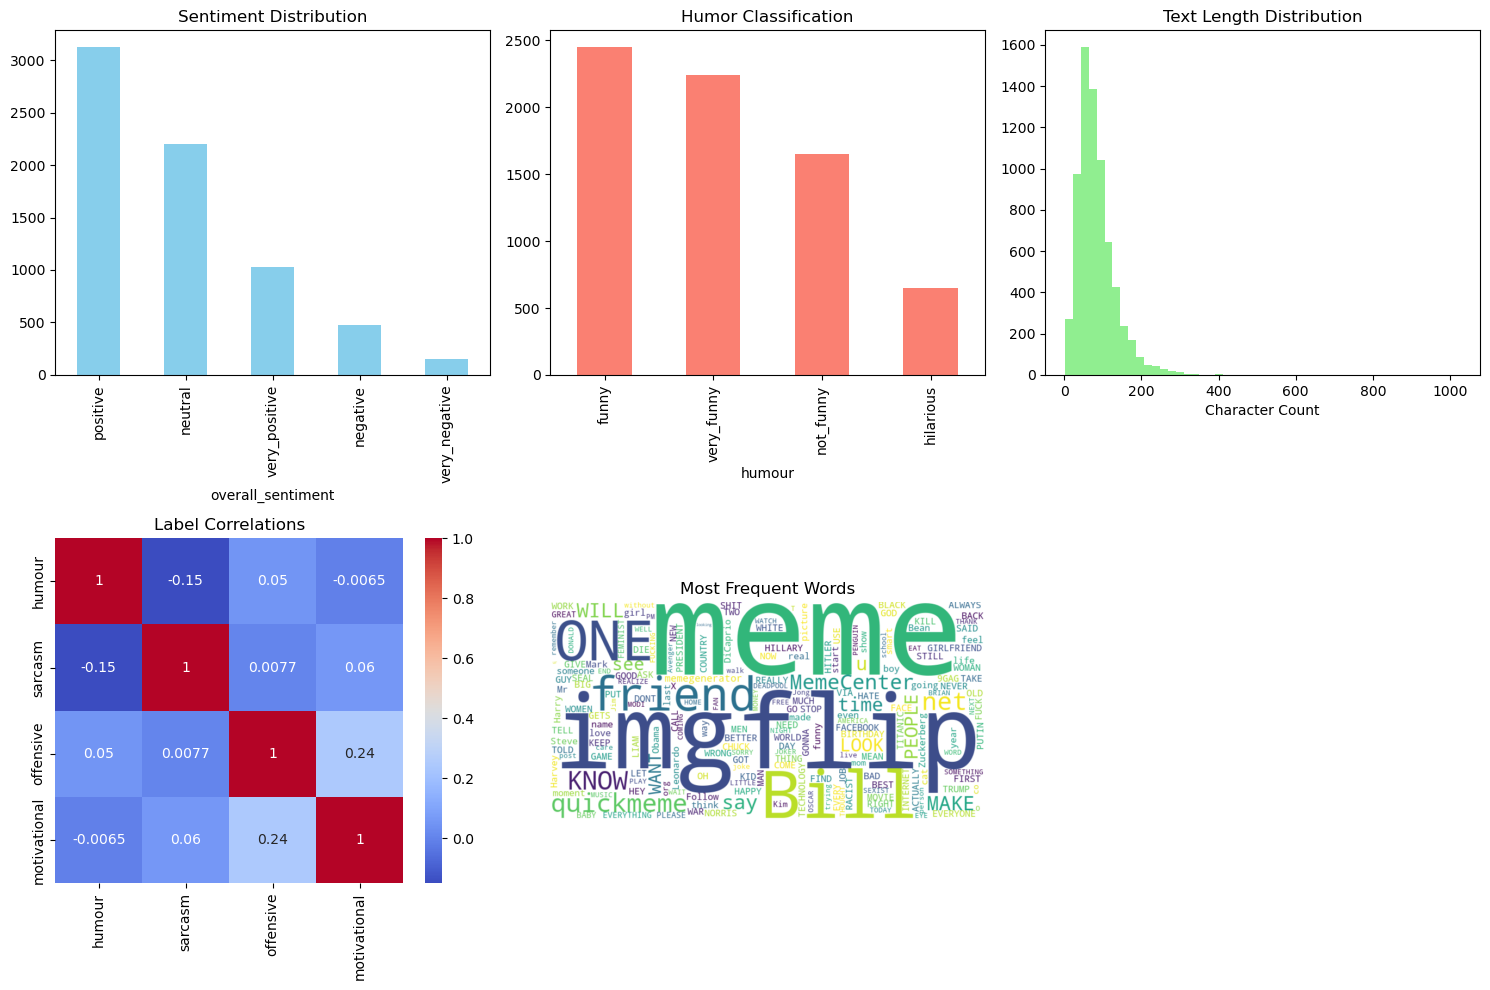


=== Advanced Statistics ===
Average text length: 82.7 characters
Unique text entries: 6939

Motivational Content:
motivational
not_motivational    4525
motivational        2467
Name: count, dtype: int64


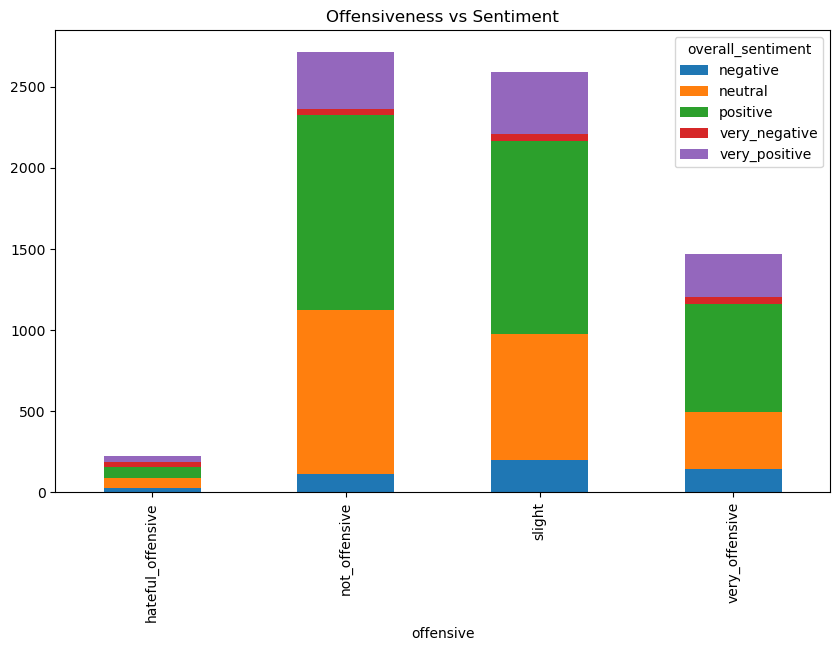

In [39]:
plt.figure(figsize=(15,10))
# Sentiment distribution
plt.subplot(2,3,1)
labels_df['overall_sentiment'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Sentiment Distribution')

# Humor distribution
plt.subplot(2,3,2)
labels_df['humour'].value_counts().plot(kind='bar', color='salmon')
plt.title('Humor Classification')

# Text length analysis
plt.subplot(2,3,3)
text_lengths = labels_df['text_corrected'].astype(str).apply(len)
plt.hist(text_lengths, bins=50, color='lightgreen')
plt.title('Text Length Distribution')
plt.xlabel('Character Count')

# Label correlations
plt.subplot(2,3,4)
correlation_matrix = labels_df[['humour', 'sarcasm', 'offensive', 'motivational']].apply(lambda x: x.factorize()[0]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Label Correlations')

# Word cloud
plt.subplot(2,3,5)
# Filter empty texts and handle NaN
clean_texts = labels_df['text_corrected'].fillna('').astype(str)
wordcloud = WordCloud(width=800, height=400, 
                     background_color='white',
                     collocations=False).generate(' '.join(clean_texts))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words')

plt.tight_layout()
plt.show()

# Advanced analysis
print("\n=== Advanced Statistics ===")
print(f"Average text length: {np.mean(text_lengths):.1f} characters")
print(f"Unique text entries: {labels_df['text_corrected'].nunique()}")

# Motivational content analysis
motivational_counts = labels_df['motivational'].value_counts()
print(f"\nMotivational Content:\n{motivational_counts}")

# Offensive content distribution
offensive_dist = labels_df.groupby(['offensive', 'overall_sentiment']).size().unstack()
offensive_dist.plot(kind='bar', stacked=True, figsize=(10,6), 
                   title='Offensiveness vs Sentiment')
plt.show()

## Loading DistilBert and ViT transformer


In [40]:
class MemeDataset(Dataset):
    def __init__(self, df, image_dir, text_max_length=128):
        self.df = df
        self.image_dir = image_dir
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        self.image_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
        self.text_max_length = text_max_length
        self.label_maps = {
            'sentiment': ['very_negative', 'negative', 'neutral', 'positive', 'very_positive'],
            'humor': ['not_funny', 'funny', 'very_funny', 'hilarious'],
            'sarcasm': ['not_sarcastic', 'general', 'twisted_meaning', 'very_twisted'],
            'offensive': ['not_offensive', 'slight', 'very_offensive', 'hateful_offensive'],
            'motivational': ['not_motivational', 'motivational']
        }

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Text processing
        text = str(row['text_corrected'])
        inputs = self.tokenizer(
            text, 
            max_length=self.text_max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        
        # Image processing
        img_path = os.path.join(self.image_dir, row['image_name'])
        image = Image.open(img_path).convert('RGB')
        pixel_values = self.image_processor(images=image, return_tensors="pt").pixel_values
        
        # Label encoding
        labels = {
            'sentiment': self.label_maps['sentiment'].index(row['overall_sentiment']),
            'humor': self.label_maps['humor'].index(row['humour']),
            'sarcasm': self.label_maps['sarcasm'].index(row['sarcasm']),
            'offensive': self.label_maps['offensive'].index(row['offensive']),
            'motivational': 1 if row['motivational'] == 'motivational' else 0
        }
        
        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'pixel_values': pixel_values.squeeze(),
            'labels': {k: torch.tensor(v, dtype=torch.long) for k, v in labels.items()}
        }

## Fusioning Layers with Neural Networks

In [41]:
class MultimodalModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.text_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.image_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.fusion = nn.Sequential(
            nn.Linear(768*2, 512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.classifiers = nn.ModuleDict({
            task: nn.Linear(512, len(dataset.label_maps[task])) 
            for task in ['sentiment', 'humor', 'sarcasm', 'offensive', 'motivational']
        })

    def forward(self, input_ids, attention_mask, pixel_values):
        text_out = self.text_model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:,0,:]
        image_out = self.image_model(pixel_values=pixel_values).last_hidden_state[:,0,:]
        fused = torch.cat([text_out, image_out], dim=1)
        fused = self.fusion(fused)
        return {task: self.classifiers[task](fused) for task in self.classifiers}

## Spliting Dataset for Training and Testing

In [42]:
labels_df = pd.read_csv('labels.csv')
train_df, test_df = train_test_split(
    labels_df, 
    test_size=0.2, 
    stratify=labels_df['overall_sentiment'],
    random_state=42
)

dataset = MemeDataset(train_df, 'images')
test_dataset = MemeDataset(test_df, 'images')

train_loader = DataLoader(dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

c:\Users\karti\anaconda3\envs\ML2\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Evaluating using F1 Score

In [43]:
def evaluate(model, loader):
    model.eval()
    task_preds = {task: [] for task in model.classifiers}
    task_labels = {task: [] for task in model.classifiers}
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels']
            
            outputs = model(**inputs)
            for task in outputs:
                preds = torch.argmax(outputs[task], dim=1).cpu().numpy()
                task_preds[task].extend(preds)
                task_labels[task].extend(labels[task].cpu().numpy())
    
    return {
        task: f1_score(task_labels[task], task_preds[task], average='macro')
        for task in task_preds
    }

## Loading the Model

In [44]:
def train(model, train_loader, test_loader, epochs=1):
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    criterion = {task: nn.CrossEntropyLoss() for task in model.classifiers}
    
    for epoch in range(epochs):
        model.train()
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        
        for batch in progress_bar:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = {k: v.to(device) for k, v in batch['labels'].items()}
            
            optimizer.zero_grad()
            outputs = model(**inputs)
            
            loss = sum(
                criterion[task](outputs[task], labels[task]) 
                for task in outputs
            )
            
            loss.backward()
            optimizer.step()
            progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})
        
        # Evaluation
        f1_scores = evaluate(model, test_loader)
        print(f"\nEpoch {epoch+1} Macro F1 Scores:")
        for task, score in f1_scores.items():
            print(f"{task.capitalize()}: {score:.4f}")

## Executing and Saving the Model

In [45]:
model = MultimodalModel().to(device)
train(model, train_loader, test_loader)
torch.save(model.state_dict(), 'memotion_model5.pth')

Epoch 1/1:  91%|█████████▏| 320/350 [29:45<02:49,  5.64s/it, loss=5.3998]c:\Users\karti\anaconda3\envs\ML2\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating: 100%|██████████| 88/88 [02:39<00:00,  1.81s/it]



Epoch 1 Macro F1 Scores:
Sentiment: 0.1399
Humor: 0.2021
Sarcasm: 0.1693
Offensive: 0.2102
Motivational: 0.3967
